# Logistic Regression

## I. Tự định nghĩa Class, Function

**Thư viện cần thiết.**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE


Class Logistic Regression để thực hiện chạy mô hình.

In [2]:
class MyLogisticRegression:
    def __init__(self, eta=0.001, tol=1e-4, maxcount=1000, lamda=0.0):
        self.eta = eta
        self.tol = tol
        self.maxcount = maxcount
        self.lamda = lamda
        self.X = None
        self.y = None
        self.w = None

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def sigmoid_stable(self, s):
        if s >= 200:
            return 1
        if s <= -200:
            return 0
        return 1 / (1 + np.exp(-s))

    def calculate_w(self, X, y, w_init, eta, tol=1e-4, max_count=10000, lamda=0.0):
        w = [w_init]
        it = 0
        d = X.shape[1]
        N = X.shape[0]
        count = 0
        check_w_after = 20
        while count < max_count:
            mix_id = np.random.permutation(N)
            for i in mix_id:
                xi = X[i, :].reshape(d, 1)
                yi = y[i]
                zi = self.sigmoid_stable(np.dot(w[-1].T, xi))
                w_new = w[-1] + eta * ((yi - zi) * xi - lamda * w[-1]) # Hiệu chỉnh L2 ở đây!
                count += 1
                if count % check_w_after == 0:
                    if np.linalg.norm(w_new - w[-check_w_after]) < tol:
                        return w
                w.append(w_new)
        return w

    def fit(self, X, y):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.X = X
        self.y = y.reshape(-1, 1)
        d = X.shape[1]
        w_init = np.random.randn(d, 1)
        self.w = self.calculate_w(X, self.y, w_init, self.eta, self.tol, self.maxcount, self.lamda)[-1]

    def predict(self, X_test):
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        y_pred = np.zeros(len(X_test))
        for i in range(len(X_test)):
            z = self.sigmoid_stable(np.dot(self.w.T, X_test[i]))
            y_pred[i] = 1 if z >= 0.5 else 0
        return y_pred


In [3]:
ctn = ['DailyRate', 'MonthlyIncome', 'MonthlyRate', 'Age', 'DistanceFromHome', 'Education', 
 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 
 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 
 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

**Hàm test với dữ liệu X, y ban đầu.**

In [4]:
def test_logistic(X, y, command="", normalize=False, use_smote=False):
    results = []

    TEST_SIZES = [0.2, 0.3, 0.4]
    C_VALUES = [0.01, 0.1, 1.0, 10.0]
    MAX_ITERS = [200, 500]

    best_f1 = -1
    y_pred_best = None
    y_test_best = None

    for test_size in TEST_SIZES:
        for C in C_VALUES:
            for max_iter in MAX_ITERS:

                start_time = time.time()

                X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                    test_size=test_size,
                    random_state=42,
                    stratify=y
                )

                if normalize:
                    scaler = StandardScaler()
                    X_train[ctn] = scaler.fit_transform(X_train[ctn])
                    X_test[ctn] = scaler.transform(X_test[ctn])

                if use_smote:
                    smote = SMOTE(random_state=42)
                    X_train, y_train = smote.fit_resample(X_train, y_train)

                model = LogisticRegression(
                    C=C,
                    max_iter=max_iter,
                )
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)

                total_time = time.time() - start_time

                if f1 > best_f1:
                    best_f1 = f1
                    y_pred_best = y_pred
                    y_test_best = y_test

                results.append({
                    "normalize": normalize,
                    "use_smote": use_smote,
                    "test_size": test_size,
                    "C": C,
                    "max_iter": max_iter,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "time": total_time
                })

    return results, y_test_best, y_pred_best


**Hàm test với dữ liệu sau khi PCA.**

In [5]:
def test_logistic_pca(X, y, command="", use_smote=False):
    results = []

    PCA_DIMS = [4, 5, 6]
    TEST_SIZES = [0.2, 0.3, 0.4]
    C_VALUES = [0.01, 0.1, 1.0, 10.0]
    MAX_ITERS = [200, 500]

    best_score = 0
    y_test_best = None
    y_pred_best = None
    best_config = None

    for n_pca in PCA_DIMS:
        for test_size in TEST_SIZES:
            for C in C_VALUES:
                for max_iter in MAX_ITERS:

                    start_time = time.time()

                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y,
                        test_size=test_size,
                        random_state=42,
                        stratify=y
                    )

                    scaler = StandardScaler()
                    X_train[ctn] = scaler.fit_transform(X_train[ctn])
                    X_test[ctn] = scaler.transform(X_test[ctn])

                    if use_smote:
                        smote = SMOTE(random_state=42)
                        X_train, y_train = smote.fit_resample(X_train, y_train)

                    pca = PCA(n_components=n_pca, random_state=42)
                    X_train = pca.fit_transform(X_train)
                    X_test = pca.transform(X_test)

                    model = LogisticRegression(
                        C=C,
                        max_iter=max_iter,
                    )
                    model.fit(X_train, y_train)

                    y_pred = model.predict(X_test)

                    acc = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred, zero_division=0)
                    recall = recall_score(y_test, y_pred, zero_division=0)
                    f1 = f1_score(y_test, y_pred, zero_division=0)

                    total_time = time.time() - start_time

                    if acc > best_score:
                        best_score = acc
                        y_test_best = y_test
                        y_pred_best = y_pred
                        best_config = (n_pca, test_size, C, max_iter)

                    results.append({
                        "pca_dim": n_pca,
                        "test_size": test_size,
                        "C": C,
                        "max_iter": max_iter,
                        "accuracy": acc,
                        "precision": precision,
                        "recall": recall,
                        "f1": f1,
                        "time": total_time
                    })

    print("Best config (PCA):", best_config)
    print("Best accuracy:", best_score)

    return results, y_test_best, y_pred_best


**Hàm test với dữ liệu sau khi LDA.**

In [6]:
def test_logistic_lda(X, y, command="", use_smote=False):
    if len(np.unique(y)) != 2:
        raise ValueError("LDA chỉ áp dụng cho dữ liệu nhị phân (2 class).")

    results = []

    TEST_SIZES = [0.2, 0.3, 0.4]
    C_VALUES = [0.01, 0.1, 1.0, 10.0]
    MAX_ITERS = [200, 500]

    best_score = 0
    y_test_best = None
    y_pred_best = None
    best_config = None

    for test_size in TEST_SIZES:
        for C in C_VALUES:
            for max_iter in MAX_ITERS:

                start_time = time.time()

                X_train, X_test, y_train, y_test = train_test_split(
                    X, y,
                    test_size=test_size,
                    random_state=42,
                    stratify=y
                )

                scaler = StandardScaler()
                X_train[ctn] = scaler.fit_transform(X_train[ctn])
                X_test[ctn] = scaler.transform(X_test[ctn])

                if use_smote:
                    smote = SMOTE(random_state=42)
                    X_train, y_train = smote.fit_resample(X_train, y_train)

                lda = LinearDiscriminantAnalysis(n_components=1)
                X_train_lda = lda.fit_transform(X_train, y_train)
                X_test_lda = lda.transform(X_test)

                model = LogisticRegression(
                    C=C,
                    max_iter=max_iter,
                )
                model.fit(X_train_lda, y_train)

                y_pred = model.predict(X_test_lda)

                acc = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)

                total_time = time.time() - start_time

                if acc > best_score:
                    best_score = acc
                    y_test_best = y_test
                    y_pred_best = y_pred
                    best_config = (test_size, C, max_iter)

                results.append({
                    "lda_dim": 1,
                    "test_size": test_size,
                    "C": C,
                    "max_iter": max_iter,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "f1": f1,
                    "time": total_time
                })

    print("Best config (LDA):", best_config)
    print("Best accuracy:", best_score)

    return results, y_test_best, y_pred_best


## II. Chuẩn bị dữ liệu

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

df = pd.read_csv('../Dataset/archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')

X = df.drop(['Attrition', 'EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1)
y = df['Attrition']

col_int32 = ['DailyRate', 'MonthlyIncome', 'MonthlyRate']
col_int16 = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate',
             'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked',
             'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
             'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
             'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
             'YearsSinceLastPromotion', 'YearsWithCurrManager']

# ép kiểu
X[col_int32] = X[col_int32].astype('int32')
X[col_int16] = X[col_int16].astype('int16')

X_origin = X.copy()
y_origin = y.copy()

# One-hot cho các cột nominal
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

encode_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'OverTime'
]

X_encoded_array = one_hot_encoder.fit_transform(X_origin[encode_cols])
encoded_columns = one_hot_encoder.get_feature_names_out(encode_cols)

X_encoded_df = pd.DataFrame(
    X_encoded_array,
    columns=encoded_columns,
    index=X_origin.index
)

# Gộp data sau one-hot
X_encode = pd.concat([X_origin.drop(columns=encode_cols), X_encoded_df], axis=1)

# Encode y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_origin)

# Continuous columns cần scale
continuous_data = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
    'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
    'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
    'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

# Standard Scaler
scaler = StandardScaler()
X_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_encode[continuous_data]),
    columns=continuous_data,
    index=X_encode.index
).astype('float32')

# Gộp cùng dữ liệu còn lại
X_final = pd.concat(
    [
        X_encode.drop(columns=continuous_data),
        X_scaled_df
    ],
    axis=1
)

# One-hot columns cũng ép về float32
one_hot_cols = X_encoded_df.columns
X_final[one_hot_cols] = X_final[one_hot_cols].astype('float32')

# Có 2 loại dữ liệu là X_origin là X ban đầu đã được One Hot và X đã được làm sạch, chuẩn hóa.
X = X_final
X_origin = X_encode

In [8]:
print(f'Số bản ghi dữ liệu: {len(X)}')
print(f'Số cột dữ liệu (tập X): {len(X.columns)}')

Số bản ghi dữ liệu: 1470
Số cột dữ liệu (tập X): 44


In [9]:
X_origin = X_origin.copy()
y_origin = y.copy()

In [10]:
X_encode.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
y

array([1, 0, 1, ..., 0, 0, 0], shape=(1470,))

## III. Dự đoán với mô hình

### Dự đoán với dữ liệu ban đầu

In [12]:
result_origin, y_test, y_pred = test_logistic(X_origin, y, command = 'Dự đoán với dữ liệu ban đầu!')

In [13]:
df_origin = pd.DataFrame(result_origin)
df_origin.head()

,normalize,use_smote,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,False,False,0.2,0.01,200,0.846939,0.750000,0.063830,0.117647,0.051688
1,False,False,0.2,0.01,500,0.840136,0.500000,0.021277,0.040816,0.098400
2,False,False,0.2,0.10,200,0.843537,0.600000,0.063830,0.115385,0.044921
3,False,False,0.2,0.10,500,0.850340,0.714286,0.106383,0.185185,0.098810
4,False,False,0.2,1.00,200,0.843537,0.600000,0.063830,0.115385,0.044659


In [14]:
df_origin_sorted = df_origin.sort_values(
    by=["accuracy", "precision", "f1", "recall"],
    ascending=[False, False, False, False]
)
df_origin_sorted.head(10)

,normalize,use_smote,test_size,C,max_iter,accuracy,precision,recall,f1,time
15,False,False,0.3,10.00,500,0.866213,0.833333,0.211268,0.337079,0.088295
11,False,False,0.3,0.10,500,0.861678,0.857143,0.169014,0.282353,0.089151
7,False,False,0.2,10.00,500,0.857143,0.777778,0.148936,0.250000,0.093776
21,False,False,0.4,1.00,500,0.857143,0.739130,0.178947,0.288136,0.082940
13,False,False,0.3,1.00,500,0.857143,0.722222,0.183099,0.292135,0.088188
9,False,False,0.3,0.01,500,0.852608,0.875000,0.098592,0.177215,0.087712
23,False,False,0.4,10.00,500,0.852041,0.785714,0.115789,0.201835,0.084808
3,False,False,0.2,0.10,500,0.850340,0.714286,0.106383,0.185185,0.098810
0,False,False,0.2,0.01,200,0.846939,0.750000,0.063830,0.117647,0.051688
6,False,False,0.2,10.00,200,0.846939,0.750000,0.063830,0.117647,0.043310


Nhận xét:
Dữ liệu đạt được Accuracy khá cao, trung bình trong các lần thực nghiệm đều trên 80%. Tuy nhiên các chỉ số khác như Recall, Precision, f1, .. rất không ổn định. Trong các lần test một số trường hợp nhỏ bất thường. Ma trận nhầm lẫn cũng không khả quan khi dữ liệu chỉ dự đoán đúng lớp đa số (ở lại, không nghỉ việc) lớp thiểu số dự đoán sai nhiều.

Lý do cho việc ACC khá cao, tuy nhiên Confusion matrix lại có nhiều sự nhầm lẫn là vì:
- Dữ liệu đầu vào quá chênh lệch tỉ lệ `yes / no = 0.16`
- Dữ liệu đầu vào chưa được chuẩn hóa dẫn đến việc khó hội tụ.
- Dữ liệu thực tế không tách lớp, nhiễu xung quanh, không tuyến tính nên mô hình Logistic rất khó dự đoán.
- Bị pha loãng dữ liệu, dữ liệu ban đầu có 35 trường, sau khi loại bỏ một số trường không cần thiết, chuẩn hóa dữ liệu với One hot, và drop first thì dữ liệu đã lên đến 44 trường.
- Đây chỉ là dữ liệu ảo do công ty IBM tạo ra, nên không phản ánh đúng được các quyết định nghỉ việc do nó phụ thuộc vào nhiều yếu tố khác nhau.


### Dự đoán với dữ liệu ban đầu đã được chuẩn hóa

In [15]:
result_origin_std, y_test_std, y_pred_std = test_logistic(X_origin, y, command = 'Dự đoán với dữ liệu ban đầu đã chuẩn hóa!', normalize = True)

In [16]:
df_origin_std = pd.DataFrame(result_origin_std)
df_origin_std.head()

,normalize,use_smote,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,True,False,0.2,0.01,200,0.853741,1.000000,0.085106,0.156863,0.018840
1,True,False,0.2,0.01,500,0.853741,1.000000,0.085106,0.156863,0.022781
2,True,False,0.2,0.10,200,0.884354,0.933333,0.297872,0.451613,0.018995
3,True,False,0.2,0.10,500,0.884354,0.933333,0.297872,0.451613,0.017416
4,True,False,0.2,1.00,200,0.863946,0.640000,0.340426,0.444444,0.019989


In [17]:
df_origin_std_sorted = df_origin_std.sort_values(
    by=["accuracy", "precision", "f1", "recall"],
    ascending=[False, False, False, False]
)
df_origin_std_sorted.head(10)

,normalize,use_smote,test_size,C,max_iter,accuracy,precision,recall,f1,time
2,True,False,0.2,0.1,200,0.884354,0.933333,0.297872,0.451613,0.018995
3,True,False,0.2,0.1,500,0.884354,0.933333,0.297872,0.451613,0.017416
12,True,False,0.3,1.0,200,0.877551,0.717949,0.394366,0.509091,0.024616
13,True,False,0.3,1.0,500,0.877551,0.717949,0.394366,0.509091,0.021701
14,True,False,0.3,10.0,200,0.877551,0.707317,0.408451,0.517857,0.029136
15,True,False,0.3,10.0,500,0.877551,0.707317,0.408451,0.517857,0.029472
20,True,False,0.4,1.0,200,0.877551,0.694915,0.431579,0.532468,0.019440
21,True,False,0.4,1.0,500,0.877551,0.694915,0.431579,0.532468,0.020156
18,True,False,0.4,0.1,200,0.874150,0.818182,0.284211,0.421875,0.026634
19,True,False,0.4,0.1,500,0.874150,0.818182,0.284211,0.421875,0.017862


Nhận xét:

Nhìn chung, kết quả của lần thực nghiệm này đã có sự cải thiện đáng kể về các chỉ số. Accuracy tăng nhẹ lên gần 0.9, các chỉ số Precision, f1, recall cũng tăng đáng kể (đáng chú ý là chỉ số precision của một số trường hợp lên gần 0.7). Tuy nhiên các trường hợp cho kết quả F1 là 0.5 vẫn rất thấp. Thời gian thực thi phụ thuộc vào số lượng các iter trong mô hình, với iter từ 500 thời gian nhiều hơn (hiển nhiên).

Ma trận nhầm lẫn trong trường hợp thực nghiệm lần này đã đều hơn việc không chuẩn hóa. Tuy nhiên sai số vẫn khá cao, thiên vị lớp đa số.

Tác động của việc chuẩn hóa là quá rõ ràng, không phải bàn cãi, dữ liệu được chuẩn hóa, đưa về cùng hệ quy chiếu làm cho các dữu liệu cân bằng hơn bớt phụ thuộc vào giá trị cao của các trường => dự đoán có phần chính xác, mô hình hội tụ nhanh hơn.

### Dự đoán với dữ liệu đã được giảm chiều bằng PCA.

In [18]:
result_pca, _, _ = test_logistic_pca(X_origin, y, command = 'Dự đoán với dữ liệu đã được giảm chiều bằng PCA!')

Best config (PCA): (6, 0.4, 0.1, 200)
Best accuracy: 0.8418367346938775


In [19]:
df_pca = pd.DataFrame(result_pca)
df_pca

,pca_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,4,0.2,0.01,200,0.840136,0.000000,0.000000,0.000000,0.021551
1,4,0.2,0.01,500,0.840136,0.000000,0.000000,0.000000,0.018992
2,4,0.2,0.10,200,0.840136,0.000000,0.000000,0.000000,0.019349
3,4,0.2,0.10,500,0.840136,0.000000,0.000000,0.000000,0.017981
4,4,0.2,1.00,200,0.840136,0.000000,0.000000,0.000000,0.019202
...,...,...,...,...,...,...,...,...,...
67,6,0.4,0.10,500,0.841837,0.750000,0.031579,0.060606,0.014985
68,6,0.4,1.00,200,0.840136,0.571429,0.042105,0.078431,0.014784
69,6,0.4,1.00,500,0.840136,0.571429,0.042105,0.078431,0.014510
70,6,0.4,10.00,200,0.840136,0.571429,0.042105,0.078431,0.014322


In [20]:
df_pca_sorted = df_pca.sort_values(
    by=["accuracy", "precision", "f1", "recall"],
    ascending=[False, False, False, False]
)
df_pca_sorted.head(10)

,pca_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
66,6,0.4,0.1,200,0.841837,0.75,0.031579,0.060606,0.014377
67,6,0.4,0.1,500,0.841837,0.75,0.031579,0.060606,0.014985
34,5,0.3,0.1,200,0.841270,1.00,0.014085,0.027778,0.014102
35,5,0.3,0.1,500,0.841270,1.00,0.014085,0.027778,0.013666
36,5,0.3,1.0,200,0.841270,1.00,0.014085,0.027778,0.013672
37,5,0.3,1.0,500,0.841270,1.00,0.014085,0.027778,0.013564
38,5,0.3,10.0,200,0.841270,1.00,0.014085,0.027778,0.013613
39,5,0.3,10.0,500,0.841270,1.00,0.014085,0.027778,0.017299
58,6,0.3,0.1,200,0.841270,1.00,0.014085,0.027778,0.014274
59,6,0.3,0.1,500,0.841270,1.00,0.014085,0.027778,0.013813


Nhận xét:

Trong lần thực nghiệm lần này với việc dữ liệu đã được giảm chiều với PCA trong các trường hợp 4, 5, 6 chiều, các chỉ số đánh giá hầu hết tương tự nhau và ở mức thấp (mặc dù ACC khá cao), dù ACC khá cao tuy nhiên đây chỉ là điểm số ảo, không phản ánh được kết quả của mô hình. D

Dữ liệu sau khi giảm chiều với PCA, trong các trường hợp chỉ làm giảm đi các nhiễu, tuy nhiên lại làm đi mất nhiều thông tin của mô hình, trong phần trực quan, mô hình chỉ dữ lại được khoảng 60% lượng thông tin với việc giảm chiều bằng PCA.

Qua đó có thể thấy việc dùng PCA gần như không phù hợp với mô hình.

### Dự đoán với dữ liệu giảm chiều bằng LDA

In [21]:
result_lda, _, _ = test_logistic_lda(X_origin, y, command = 'Dự đoán với dữ liệu đã được giảm chiều bằng LDA!')

Best config (LDA): (0.3, 1.0, 200)
Best accuracy: 0.8775510204081632


In [22]:
df_lda = pd.DataFrame(result_lda)
df_lda.head()

,lda_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,1,0.2,0.01,200,0.863946,1.000000,0.148936,0.259259,0.028696
1,1,0.2,0.01,500,0.863946,1.000000,0.148936,0.259259,0.026675
2,1,0.2,0.10,200,0.863946,0.640000,0.340426,0.444444,0.027179
3,1,0.2,0.10,500,0.863946,0.640000,0.340426,0.444444,0.025442
4,1,0.2,1.00,200,0.867347,0.642857,0.382979,0.480000,0.032735


In [23]:
df_lda_sorted = df_lda.sort_values(
    by=["accuracy", "precision", "f1", "recall"],
    ascending=[False, False, False, False]
)
df_lda_sorted.head(10)

,lda_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
12,1,0.3,1.0,200,0.877551,0.707317,0.408451,0.517857,0.024377
13,1,0.3,1.0,500,0.877551,0.707317,0.408451,0.517857,0.023543
14,1,0.3,10.0,200,0.877551,0.707317,0.408451,0.517857,0.023523
15,1,0.3,10.0,500,0.877551,0.707317,0.408451,0.517857,0.023587
10,1,0.3,0.1,200,0.873016,0.692308,0.380282,0.490909,0.023680
11,1,0.3,0.1,500,0.873016,0.692308,0.380282,0.490909,0.023514
18,1,0.4,0.1,200,0.870748,0.661017,0.410526,0.506494,0.022967
19,1,0.4,0.1,500,0.870748,0.661017,0.410526,0.506494,0.030390
4,1,0.2,1.0,200,0.867347,0.642857,0.382979,0.480000,0.032735
5,1,0.2,1.0,500,0.867347,0.642857,0.382979,0.480000,0.027671


Nhận xét:

Ma trận nhầm lẫn, ACC, Precision khá cao, tuy nhiên chưa cao bằng với dữ liệu ban đầu, tuy nhiên f1, recall còn hơi thấp.

Kết quả với việc giảm chiều bằng LDA cải thiệt rõ rệt so với PCA, nguyên do là LDA không chỉ lấy những chiều có nhiều thông tin mà chiều đó còn tách được lớp cao nhất, qua đó sử dụng mô hình dự đoán Logistic sẽ cho kết quả cao hơn so với việc sử dụng PCA.

Do chỉ thực hiện fit vào model với 1 chiều nên thời gian nhanh hơn rất nhiều.

### Thực nghiệm lại sử dụng cân bằng dữ liệu

#### Dữ liệu ban đầu đã được chuẩn hóa

In [24]:
result_origin_std_smote, y_test_smote_std, y_pred_smote_std = test_logistic(X_origin, y, command = 'Dự đoán với dữ liệu ban đầu!', normalize = True, use_smote = True)
df_origin_std_smote = pd.DataFrame(result_origin_std_smote)
df_origin_std_smote.head()

,normalize,use_smote,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,True,True,0.2,0.01,200,0.744898,0.344444,0.659574,0.452555,0.513941
1,True,True,0.2,0.01,500,0.744898,0.344444,0.659574,0.452555,0.027275
2,True,True,0.2,0.10,200,0.775510,0.388235,0.702128,0.500000,0.054789
3,True,True,0.2,0.10,500,0.775510,0.388235,0.702128,0.500000,0.041220
4,True,True,0.2,1.00,200,0.772109,0.378049,0.659574,0.480620,0.056404


Nhận xét:

Sau cân bằng hóa dữ liệu được thêm vào nhiều hơn, nên mô hình học được theo cách của việc cân bằng dữ liệu, tuy nhiên việc dự đoán lại cho kết quả có điểm của các chỉ số nhỏ hơn, điều này là dễ hiểu vì việc học theo dữ liệu nguyên mẫu đã giúp mô hình trở nên học đúng hơn, không hề thiên vị lớp đa số hay thiểu số. Minh chứng ở đây là ma trận nhầm lẫn của mô hình đã được cân bằng hơn tuy nhiên không thể phủ nhận nó vẫn còn dự đoán sai tương đối nhiều.

#### Dữ liệu đã giảm chiều bằng PCA

In [25]:
result_pca_std_smote, _, _ = test_logistic_pca(X_origin, y, command = 'Dự đoán với dữ liệu PCA!', use_smote = True)
df_pca_std_smote = pd.DataFrame(result_pca_std_smote)
df_pca_std_smote.head()

Best config (PCA): (6, 0.4, 1.0, 200)
Best accuracy: 0.7074829931972789


,pca_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,4,0.2,0.01,200,0.659864,0.269565,0.659574,0.382716,0.046702
1,4,0.2,0.01,500,0.659864,0.269565,0.659574,0.382716,0.043770
2,4,0.2,0.10,200,0.659864,0.273504,0.680851,0.390244,0.043221
3,4,0.2,0.10,500,0.659864,0.273504,0.680851,0.390244,0.029505
4,4,0.2,1.00,200,0.663265,0.275862,0.680851,0.392638,0.024488


In [26]:
df_pca_std_smote

,pca_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,4,0.2,0.01,200,0.659864,0.269565,0.659574,0.382716,0.046702
1,4,0.2,0.01,500,0.659864,0.269565,0.659574,0.382716,0.043770
2,4,0.2,0.10,200,0.659864,0.273504,0.680851,0.390244,0.043221
3,4,0.2,0.10,500,0.659864,0.273504,0.680851,0.390244,0.029505
4,4,0.2,1.00,200,0.663265,0.275862,0.680851,0.392638,0.024488
...,...,...,...,...,...,...,...,...,...
67,6,0.4,0.10,500,0.705782,0.308824,0.663158,0.421405,0.020600
68,6,0.4,1.00,200,0.707483,0.310345,0.663158,0.422819,0.041673
69,6,0.4,1.00,500,0.707483,0.310345,0.663158,0.422819,0.021292
70,6,0.4,10.00,200,0.707483,0.310345,0.663158,0.422819,0.020322


#### Dữ liệu đã được giảm chiều bằng LDA

In [27]:
result_lda_std_smote, _, _ = test_logistic_lda(X_origin, y, command = 'Dự đoán với dữ liệu LDA', use_smote = True)
df_lda_std_smote = pd.DataFrame(result_lda_std_smote)
df_lda_std_smote.head()

Best config (LDA): (0.3, 0.1, 200)
Best accuracy: 0.7868480725623582


,lda_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,1,0.2,0.01,200,0.751701,0.3375,0.574468,0.425197,0.050500
1,1,0.2,0.01,500,0.751701,0.3375,0.574468,0.425197,0.062216
2,1,0.2,0.10,200,0.751701,0.3375,0.574468,0.425197,0.081258
3,1,0.2,0.10,500,0.751701,0.3375,0.574468,0.425197,0.066570
4,1,0.2,1.00,200,0.751701,0.3375,0.574468,0.425197,0.084086


In [28]:
df_lda_std_smote

,lda_dim,test_size,C,max_iter,accuracy,precision,recall,f1,time
0,1,0.2,0.01,200,0.751701,0.337500,0.574468,0.425197,0.050500
1,1,0.2,0.01,500,0.751701,0.337500,0.574468,0.425197,0.062216
2,1,0.2,0.10,200,0.751701,0.337500,0.574468,0.425197,0.081258
3,1,0.2,0.10,500,0.751701,0.337500,0.574468,0.425197,0.066570
4,1,0.2,1.00,200,0.751701,0.337500,0.574468,0.425197,0.084086
5,1,0.2,1.00,500,0.751701,0.337500,0.574468,0.425197,0.091377
6,1,0.2,10.00,200,0.751701,0.337500,0.574468,0.425197,0.081305
7,1,0.2,10.00,500,0.751701,0.337500,0.574468,0.425197,0.062806
8,1,0.3,0.01,200,0.773243,0.380165,0.647887,0.479167,0.063317
9,1,0.3,0.01,500,0.773243,0.380165,0.647887,0.479167,0.062434


Bằng 2 cách giảm chiều PCA, LDA cho kết quả cũng tương đối thấp, chúng tôi thực hiện thêm mẫu sau đó mới sử dụng giảm chiều bằng LDA, PCA, LDA cho kết quả tốt hơn do được phân lớp tốt sau giảm chiều.

Mặc dù Accuracy đạt gần 79%, nhưng Precision thấp cho thấy mô hình còn nhiều false positive. Tuy nhiên Recall đạt trên 60%, chứng tỏ mô hình có khả năng phát hiện tương đối tốt lớp thiểu số. Do dữ liệu mất cân bằng, F1-score được sử dụng làm chỉ số đánh giá chính.

## IV. Trực quan hóa kết quả

#### So sánh tương quan giữa các mô hình

**Với dữ liệu chưa ban đầu được chuẩn hóa**

In [29]:
def plot_confusion_np(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    plt.imshow(cm)
    plt.colorbar()
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center")

    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


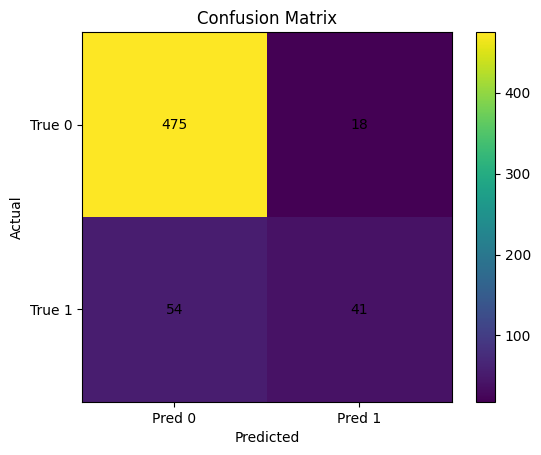

In [30]:
plot_confusion_np(y_test_std, y_pred_std)

Kết quả thực nghiệm cho thấy sự không tương thích giữa mô hình và yêu cầu của bài toán phân loại. Mặc dù quá trình chuẩn hóa dữ liệu tối ưu hóa khả năng nhận diện Lớp 0 (đa số), hiệu suất trên Lớp 1 (thiểu số) ghi nhận sự suy giảm đáng kể với tỷ lệ bỏ sót (False Negative) xấp xỉ 60%.

Chỉ số độ chính xác tổng thể (Accuracy) 88% phản ánh sự thiên lệch do mất cân bằng dữ liệu hơn là năng lực dự báo thực tế. Đối với mục tiêu phát hiện các trường hợp thuộc Lớp 1, mô hình chưa đáp ứng tiêu chuẩn triển khai. Yêu cầu xử lý vấn đề mất cân bằng mẫu là cần thiết để đảm bảo độ tin cậy của hệ thống.

**Với dữ liệu đã sử dụng Smote**

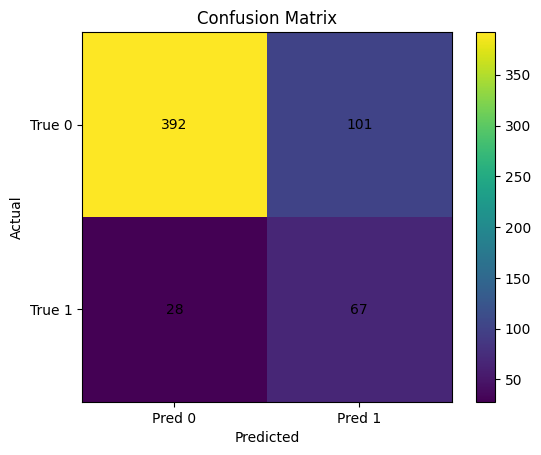

In [31]:
plot_confusion_np(y_test_smote_std, y_pred_smote_std)

Kỹ thuật SMOTE đã cải thiện rõ rệt khả năng phát hiện Lớp 1 (thiểu số), giúp mô hình không còn bỏ sót nhiều như trước (68 trường hợp được phát hiện đúng). Tuy nhiên, sự điều chỉnh này gây ra tác dụng phụ lớn: tỷ lệ báo động giả (False Positive) tăng đột biến lên 101 trường hợp, làm giảm mạnh độ tin cậy khi dự báo lớp dương tính.

#### Dưới đây là bảng so sánh kết quả Accuracy

In [32]:
def plot_multiple_series(series_dict, xlabel="", ylabel="", title="", figsize=(12, 6)):
    plt.figure(figsize=figsize)

    for label, series in series_dict.items():
        plt.plot(series.index, series.values, marker='o', label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


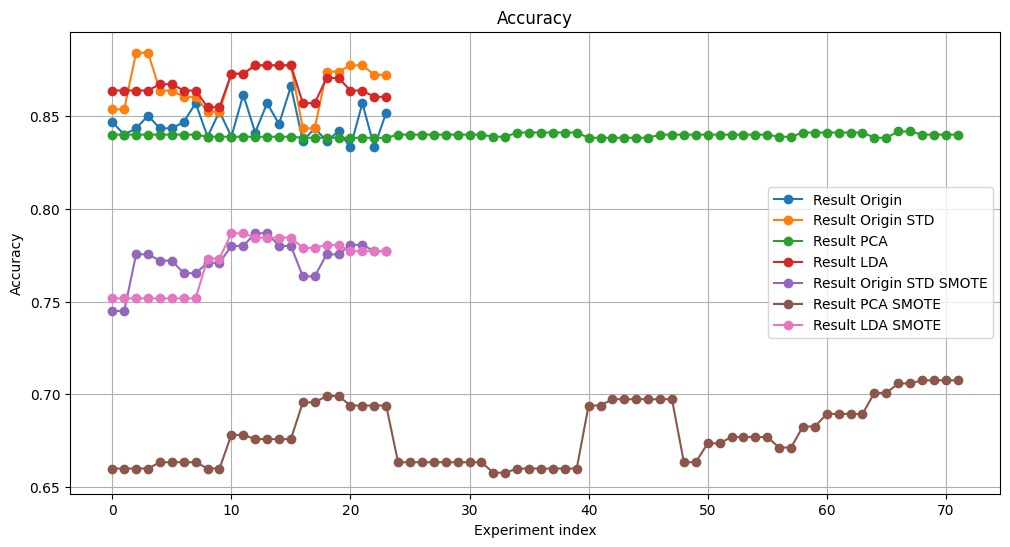

In [33]:
plot_multiple_series(
    {
        "Result Origin": df_origin['accuracy'],
        "Result Origin STD": df_origin_std['accuracy'],
        "Result PCA": df_pca['accuracy'],
        "Result LDA": df_lda['accuracy'],
        "Result Origin STD SMOTE": df_origin_std_smote['accuracy'],
        "Result PCA SMOTE": df_pca_std_smote['accuracy'],
        "Result LDA SMOTE": df_lda_std_smote['accuracy']
    },
    xlabel="Experiment index",
    ylabel="Accuracy",
    title="Accuracy"
)

#### Dưới đây là kết quả so sánh Precision,

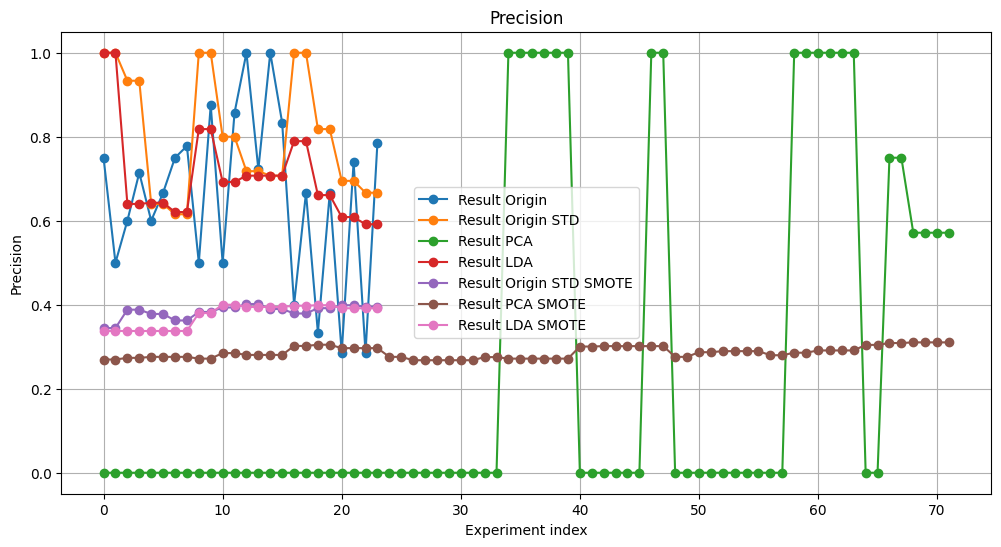

In [34]:
plot_multiple_series(
    {
        "Result Origin": df_origin['precision'],
        "Result Origin STD": df_origin_std['precision'],
        "Result PCA": df_pca['precision'],
        "Result LDA": df_lda['precision'],
        "Result Origin STD SMOTE": df_origin_std_smote['precision'],
        "Result PCA SMOTE": df_pca_std_smote['precision'],
        "Result LDA SMOTE": df_lda_std_smote['precision']
    },
    xlabel="Experiment index",
    ylabel="Precision",
    title="Precision"
)

#### Dưới đây là kết quả so sánh Recall

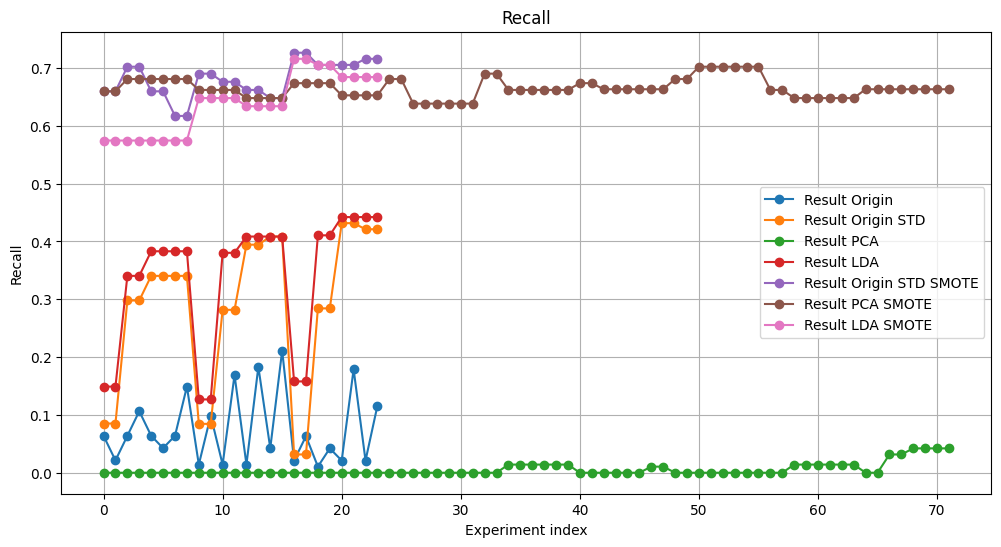

In [35]:
plot_multiple_series(
    {
        "Result Origin": df_origin['recall'],
        "Result Origin STD": df_origin_std['recall'],
        "Result PCA": df_pca['recall'],
        "Result LDA": df_lda['recall'],
        "Result Origin STD SMOTE": df_origin_std_smote['recall'],
        "Result PCA SMOTE": df_pca_std_smote['recall'],
        "Result LDA SMOTE": df_lda_std_smote['recall']
    },
    xlabel="Experiment index",
    ylabel="Recall",
    title="Recall"
)

#### Bảng so sánh f1

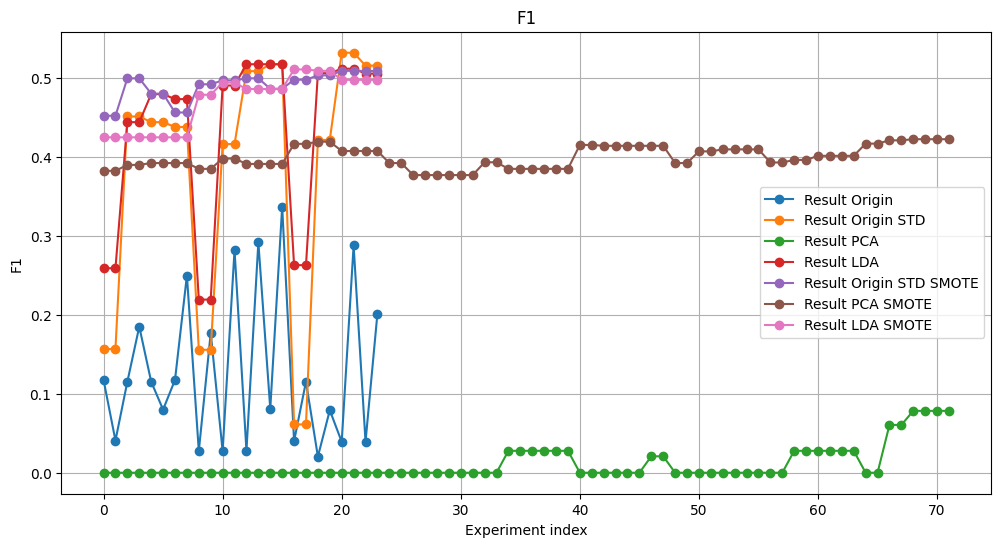

In [36]:
plot_multiple_series(
    {
        "Result Origin": df_origin['f1'],
        "Result Origin STD": df_origin_std['f1'],
        "Result PCA": df_pca['f1'],
        "Result LDA": df_lda['f1'],
        "Result Origin STD SMOTE": df_origin_std_smote['f1'],
        "Result PCA SMOTE": df_pca_std_smote['f1'],
        "Result LDA SMOTE": df_lda_std_smote['f1']
    },
    xlabel="Experiment index",
    ylabel="F1",
    title="F1"
)

Mô hình có phù hợp hay không?

Logistic Regression là mô hình tuyến tính, có khả năng diễn giải tốt, phù hợp với dữ liệu có cả đặc trưng liên tục và phân loại (sau khi mã hóa one-hot).

Với dữ liệu có 35 thuộc tính (16 liên tục, 19 phân loại) và phân bố nhãn mất cân bằng (yes/no ≈ 0.16), mô hình Logistic Regression nhìn chung vẫn phù hợp vì đơn giản, dễ huấn luyện và cho kết quả ổn định. Tuy nhiên, ở các trường hợp không giảm chiều hoặc dùng PCA, mô hình có dấu hiệu thiên lệch về lớp đa số (no), thể hiện qua ma trận nhầm lẫn mất cân đối.

Về kết quả của mô hình, khi không giảm chiều hoặc chỉ giảm chiều bằng PCA, mô hình đạt độ chính xác khoảng 0.8x, tuy nhiên ma trận nhầm lẫn cho thấy dữ liệu phân bố không đều: mô hình có xu hướng dự đoán lớp “no” nhiều hơn, dẫn tới khả năng nhận diện lớp “yes” (thiểu số) kém hơn. Điều này xuất phát từ sự mất cân bằng trong dữ liệu (class imbalance), khiến mô hình “nghiêng” về phía lớp chiếm đa số để tối ưu hóa độ chính xác tổng thể.

![Biểu đồ so sánh dự đoán và thực tế sử dụng PCA](../assets/image/img_1.png)     

Khi sử dụng LDA (Linear Discriminant Analysis) trước Logistic Regression, kết quả cải thiện rõ rệt.
Lý do là LDA vừa giảm chiều, vừa giữ lại thông tin phân tách giữa các lớp, giúp dữ liệu sau biến đổi có ranh giới tuyến tính rõ ràng hơn. Mô hình Logistic Regression vì vậy học được ranh giới phân lớp hiệu quả hơn, giảm thiểu nhầm lẫn và cải thiện khả năng nhận diện lớp thiểu số.

![Biểu đồ so sánh dự đoán và thực tế sử dụng LDA](../assets/image/img.png)
